In [64]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

In [65]:
def calc_price(theta1, theta2, mu1, mu2, cost):
    """compute each insurer's price (assumes interior solution)"""
    p1 = (2.*theta1*mu1+theta2*mu2)/3. + cost
    p2 = (2.*theta2*mu2+theta1*mu1)/3. + cost
    return np.maximum(p1,0), np.maximum(p2,0)
  
    
def calc_t(theta1, theta2, mu1, mu2, cost, listprice):
    """compute the proportion of people choosing each insurer"""
    p1, p2 = calc_price(theta1, theta2, mu1, mu2, cost)
    t_hat = .5 + (p2 - p1)/(2.*cost)
    return t_hat


def calc_profits(theta1, theta2, mu1, mu2, cost, listprice):
    """compute profits for each firm"""
    
    #interior solution
    p1, p2 = calc_price(theta1, theta2, mu1, mu2, cost)
    t1 = calc_t(theta1, theta2, mu1, mu2, cost, listprice)
    if t1 > 1 or t1 < 0:
        t1 = -1
    
    #corner solution
    p0 = (listprice + mu1*theta1)/2
    t0 = (listprice - mu1*theta1)/(2*cost)
    
    return max([t0*(p0-theta1*mu1),t1*(p1-theta1*mu1), 0])


def hosp_profits(theta1,theta2,mu1,mu2,cost, listprice):
    
    #need to fix this to account for the fact that the hospitals profit is decreasing...
    t1 = calc_t(theta1, theta2, mu1, mu2, cost, listprice)
    t2 = calc_t(theta2, theta1, mu2, mu1, cost, listprice)

    return t1*theta1*mu1 +  t2*theta2*mu2 


def outside_seq(theta1,mu1,cost,listprice):
    """go through kkt to find a solution"""
    #three solutions to firms optimization problem
    p0, p1, p2 = listprice, (listprice + (mu1*theta1))/2, listprice - cost  
    t0,t1,t2 = 0, (listprice - mu1*theta1)/(2*cost) ,1
    #double check t1 is a valid solution
    if t1 > 1 or t1 < 0:
        t1 = -1
        
    #find the max
    ind = np.argmax([p0*t0, p1*t1, p2*t2])
    return mu1*theta1*([t0,t1,t2][ind])

    
def outside_simlt(mu1,cost,listprice):
    """outside option in simult case"""
    return mu1*(listprice - cost)/2

    
#arbitrary outside option...
def nash_in_nash(theta1, theta2, mu1, mu2, cost, listprice, outside):
    term1 = calc_profits(theta1, theta2, mu1, mu2, cost, listprice)
    term2 = max(hosp_profits(theta1,theta2,mu1,mu2,cost, listprice)-outside,0)
    obj = -1*(term1*term2)**.5
    return obj

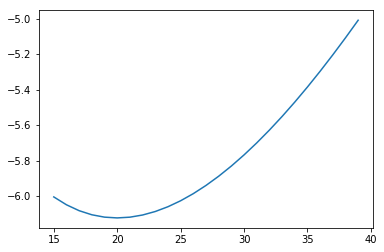

In [66]:

plt.plot([i for i in range(15,40)], [nash_in_nash(i, 20, .5, .5, 10, 20, outside_simlt(.5,10,20)) 
                                      for i in range(15,40)])


In [67]:
def bargain_helper(theta1, theta2, mu1, mu2, cost, listprice):
    """solve each firm 1s optimization holding theta 2 fixed"""
    outside = outside_simlt(mu2,cost,listprice)
    result = minimize(nash_in_nash, theta1, args=(theta2, mu1, mu2, cost, listprice, outside),
                      method='Nelder-Mead', options={'disp': False})
    return result.x


print(bargain_helper(17, 17, .5, .5, 10, 20))

[19.48214111]


In [60]:
def simult_bargain(theta1, theta2, mu1, mu2, cost, listprice):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables
    diff =  theta1

    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        theta1 = bargain_helper(theta1, theta2, mu1, mu2, cost, listprice)
        theta2 = bargain_helper(theta2, theta1, mu2, mu1, cost,  listprice)
        
        #update loop variables
        diff = np.abs(np.max(theta1 - theta2))
        maxiter = maxiter-1
        
    return theta1, theta2


print(simult_bargain(18,18,.5,.5,10,20))

(array([19.99998444]), array([19.99997741]))


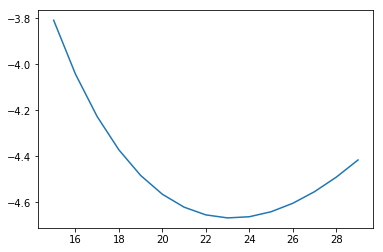

In [81]:
def bargain_helper_seq(theta1, mu1, mu2, cost, listprice):
    """solve each firm 1s optimization holding theta 2 fixed"""
    outside = outside_seq(theta1,mu1,cost,listprice)
    result = minimize(nash_in_nash, 10., args=(theta1, mu2, mu1, cost, listprice, outside),
                      method='Nelder-Mead', options={'disp': False})
    return result.x


def seq_obj(theta1, mu1, mu2, cost, listprice):
    """ theta1 is a guess for the first stage """
    
    theta2 = bargain_helper_seq(theta1, mu2, mu1, cost, listprice)
    outside1 = outside_simlt(mu1,cost,listprice)
    
    return nash_in_nash(theta1, theta2, mu1, mu2, cost, listprice, outside1)

plt.plot([i for i in range(15,30)],  [seq_obj(i, .5, .5, 10, 30) for i in range(15,30)])

In [79]:
def seq_bargain(theta1, mu1, mu2, cost, listprice):
    """solve the bargaining problems seperately,
    then solve for the solution"""   
    #only compute no deal 1x for initial
    result = minimize(seq_obj, theta1, args=(mu1, mu2, cost, listprice),
                      method='Nelder-Mead', options={'disp': False})
    theta1 = result.x
    theta2 = bargain_helper(theta1, theta1, mu2, mu1, cost, listprice)
    return theta1, theta2


print(seq_bargain(18,.5,.5,10,30))

(array([23.20548706]), array([19.61652564]))


In [76]:
def make_table(arg, steps, params):
    min_arg, max_arg, no_step = steps
    
    cols = ['eq_type','distance_cost','mc1','mc2','profit1','profit2','hosp_profit','share1','share2']
    
    indep_var = np.linspace(min_arg, max_arg, no_step)
    results = []
    
    for var in indep_var:
        param_copy = list(params)
        param_copy[arg] = var
        mu1,mu2,cost,listprice = param_copy
        for eq_type in ['Simultaneous', 'Sequential']:
            
            mc1,mc2 = 15, 15
            
            if eq_type == 'Simultaneous':
                mc1,mc2 = simult_bargain(mc1, mc2, mu1, mu2, cost, listprice)
            else:
                mc1,mc2 = seq_bargain(mc1, mu1, mu2, cost, listprice)
            mc1, mc2 = mc1[0],mc2[0]
            profit1 = calc_profits(mc1, mc2, mu1, mu2, cost,listprice)
            profit2 = calc_profits(mc2, mc1, mu2, mu1, cost,listprice)
            hosp_prof = hosp_profits(mc1, mc2, mu1, mu2, cost,listprice)
            share1 = calc_t(mc1, mc2, mu1, mu2, cost,listprice)
            share2 = 1-share1
            results.append([eq_type,cost,mc1,mc2,profit1,profit2,hosp_prof, share1,share2])
            
        
    return pd.DataFrame(data=results, columns=cols)
    

make_table(2,(10,13,5), (.5,.5,10,30))

,eq_type,distance_cost,mc1,mc2,profit1,profit2,hosp_profit,share1,share2
0,Simultaneous,10.00,24.000017,24.000019,13.224990,13.224989,12.000009,0.500000,0.500000
1,Sequential,10.00,28.625427,23.711809,10.699095,13.391229,12.983711,0.459053,0.540947
2,Simultaneous,10.75,23.700033,23.699995,12.463296,12.463317,11.850007,0.500000,0.500000
3,Sequential,10.75,28.424652,23.297146,10.049474,12.681143,12.828545,0.460252,0.539748
4,Simultaneous,11.50,23.400011,23.400007,11.801951,11.801953,11.700004,0.500000,0.500000
5,Sequential,11.50,28.181030,22.890895,9.504490,12.061238,12.666584,0.461666,0.538334
6,Simultaneous,12.25,23.100019,23.100015,11.222491,11.222493,11.550008,0.500000,0.500000
7,Sequential,12.25,27.904724,22.493926,9.040879,11.514424,12.500082,0.463192,0.536808
8,Simultaneous,13.00,22.800012,22.800025,10.710764,10.710758,11.400009,0.500000,0.500000
9,Sequential,13.00,27.602966,22.106297,8.641868,11.027917,12.330478,0.464765,0.535235


In [88]:
table1 = make_table(2,(10,15,6), (.5,.5,10,30))
table2 = make_table(3,(25,30,6), (.5,.5,10,30))

table1.to_csv('distance_cost_table.csv',float_format='%.3f',index=False)
table2.to_csv('listprice_table.csv',float_format='%.3f',index=False)